# Rotation MNIST — back to the trenches
In this notebook, we make use of HMC to estimate the posterior predictive distribution over the rotating MNIST dataset with missing rotations, which we call _trenches_.

In [1]:
import jax
import distrax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [2]:
# from rebayes.utils import datasets
from dynamax.utils import datasets
from rebayes import hamiltonian_monte_carlo as rhmc

In [3]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

In [170]:
class MLP(nn.Module):
    dim_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        return x


class CNN(nn.Module):
    dim_out: int
    activation: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(6, (5, 5), padding="SAME")(x)
        x = self.activation(x)
        x = nn.avg_pool(x, (2, 2), padding="SAME")
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        return x

# Rotating MNIST

In [763]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=1, maxangle=180)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)


# X_train = X_train.reshape(-1, 28, 28)
# X_test = X_test.reshape(-1, 28, 28)
num_train, *dim_input = X_train.shape

In [764]:
batch_size = 100
batch = (batch_size, *dim_input)
model = MLP(1, activation=nn.elu)
batch = jnp.ones(batch)

params_init = model.init(key_init, batch)

In [765]:
%%time

priors = rhmc.PriorParam(scale_obs=2.0, scale_weight=1/2)
# rebayes model
rmodel = rhmc.RebayesHMC(
    apply_fn=model.apply,
    priors=priors,
    log_joint=rhmc.log_joint,
    num_samples=100,
    num_warmup=200
)


num_eval = 2000
X_eval = X_train[:num_eval]
y_eval = y_train[:num_eval]

sampled_params = rmodel.update_state(params_init, X_eval, y_eval, key_train, tqdm=True)
sampled_params = jax.block_until_ready(sampled_params)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 26 s, sys: 719 ms, total: 26.8 s
Wall time: 1min 52s


## Evaluation metrics

In [766]:
yhat_samples = rmodel.eval(sampled_params, X_test).squeeze()
yhat_train_samples = rmodel.eval(sampled_params, X_train).squeeze()

### Mean absolute error

In [767]:
yhat_test = yhat_samples.mean(axis=0)
metric_mae = jnp.abs(yhat_test - y_test).mean()
metric_mae

Array(5.582807, dtype=float32)

In [768]:
metric_rmse = jnp.sqrt(jnp.power(yhat_test - y_test, 2).mean())
metric_rmse

Array(10.958743, dtype=float32)

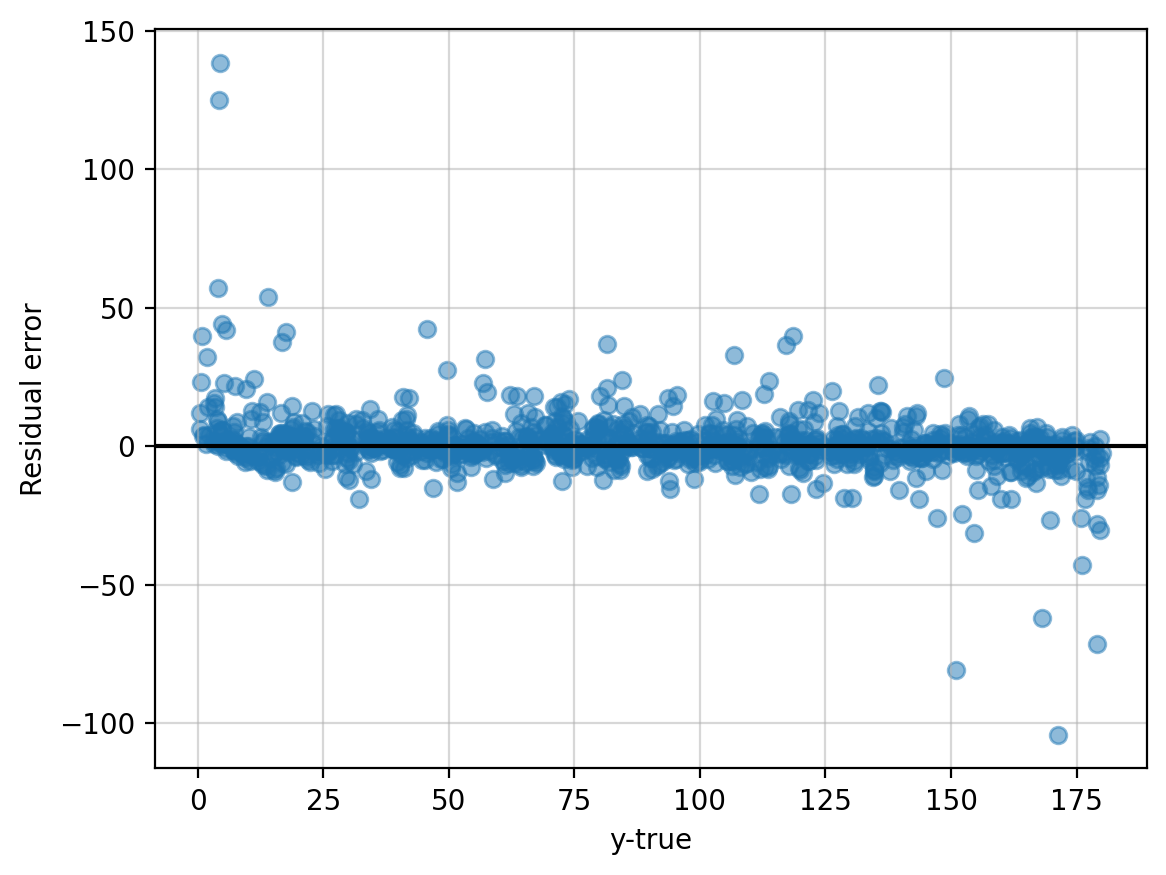

In [769]:
residual_err = yhat_test - y_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("Residual error")
plt.xlabel("y-true")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.5)

### Negative marginal log-likelihood

The marginal log-likelihood can be approximated as
$$
\begin{aligned}
    \log p(y \vert x, \cal D)
    &= \log\int p({\bf w} \vert \cal D) p(y \vert x, {\bf w}) d{\bf w}\\
    &= \log \mathbb{E}_{p({\bf w}\vert \cal D)}[p(y \vert x, {\bf w})] \\
    &\leq \mathbb{E}_{p({\bf w}\vert \cal D)}[\log p(y \vert x, {\bf w})] \\
    &\approx \frac{1}{S}\sum_{s=1}^S\log p\left(y \vert x, {\bf w}^{(s)}\right); {\bf w}^{(s)} \sim p(\cdot \vert \cal D)
\end{aligned} 
$$

In [802]:
means = yhat_samples.mean(axis=0).sum()
nll = -distrax.Normal(means, priors.scale_obs).log_prob(y_test).mean()
nll

Array(1.02707584e+09, dtype=float32)

## The trenches

1. $[0, 45] \cup [90, 135]$

In [803]:
map_trench_1 = (y_train  >= 0) & (y_train <= 45)
map_trench_2 = (y_train >= 90) & (y_train <= 135)
map_trench = map_trench_1 | map_trench_2

<AxesSubplot: ylabel='Count'>

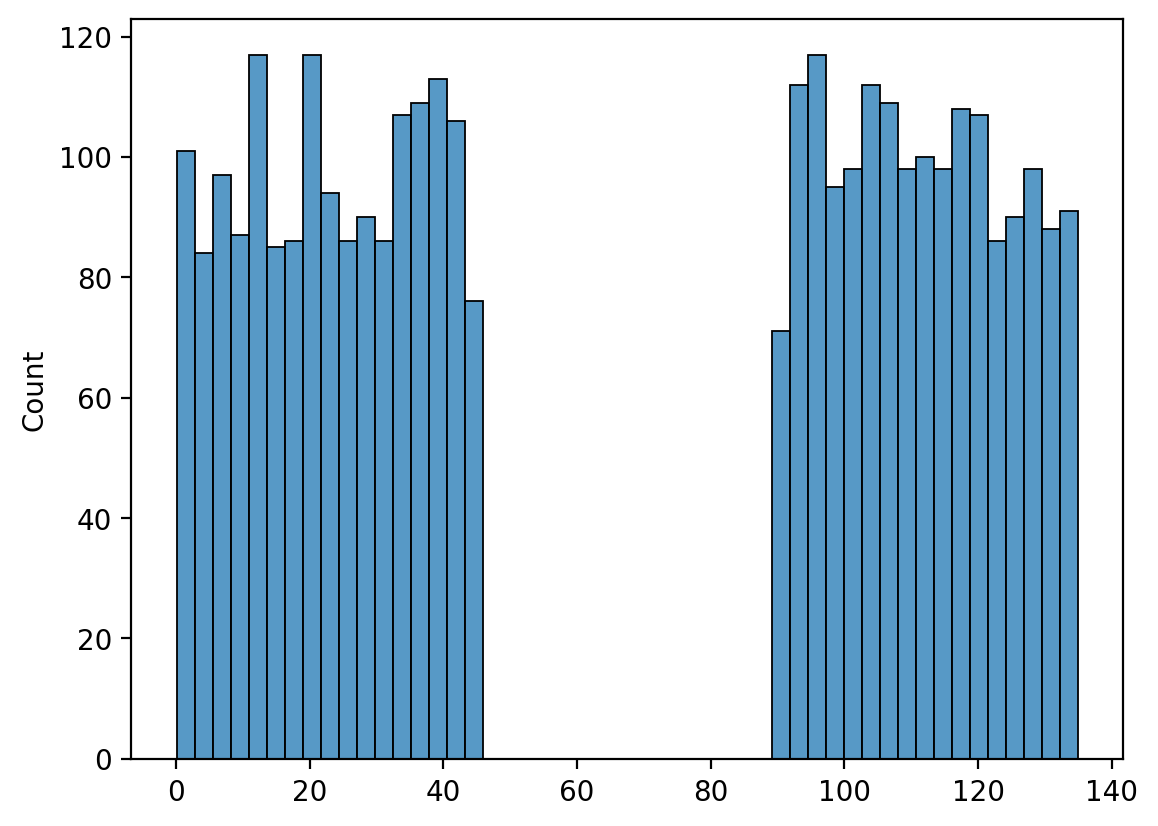

In [804]:
y_eval = y_train[map_trench]
X_eval = X_train[map_trench]
sns.histplot(y_eval, bins=50)

In [805]:
%%time
sampled_params = rmodel.update_state(params_init, X_eval, y_eval, key_train, tqdm=True)
sampled_params = jax.block_until_ready(sampled_params)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 25.9 s, sys: 474 ms, total: 26.4 s
Wall time: 2min 16s


## Evaluation metrics

In [806]:
yhat_samples = rmodel.eval(sampled_params, X_test).squeeze()
yhat_train_samples = rmodel.eval(sampled_params, X_train).squeeze()

### Mean absolute error

In [807]:
yhat_test = yhat_samples.mean(axis=0)
metric_mae = jnp.abs(yhat_test - y_test).mean()
metric_mae

Array(20.717396, dtype=float32)

In [808]:
metric_rmse = jnp.sqrt(jnp.power(yhat_test - y_test, 2).mean())
metric_rmse

Array(40.359135, dtype=float32)

In [809]:
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 180, 100)

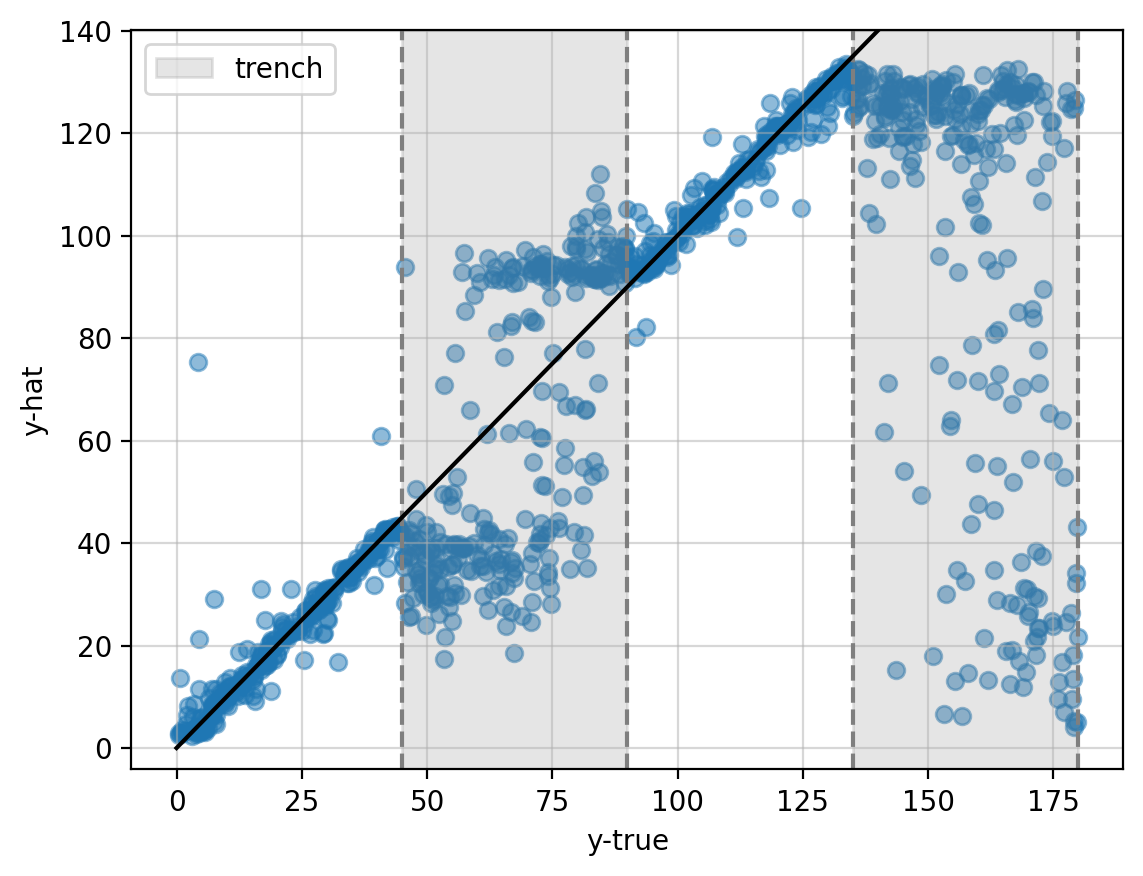

In [810]:
residual_err = yhat_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

In [811]:
n_rotations = 181
rotations = np.linspace(0, 180, n_rotations)

# group_ix = jnp.digitize(yhat_test, rotations)
group_ix = jnp.digitize(y_test, rotations)

summary_est = pd.DataFrame({
    "y_hat": np.array(yhat_test),
    "group": np.array(group_ix),
}).groupby("group").mean()


summary_est_std = pd.DataFrame({
    "y_hat_std": np.array(yhat_test),
    "group": np.array(group_ix),
}).groupby("group").std()


summary_true = pd.DataFrame({
    "y_true": np.array(y_test),
    "group": np.array(group_ix),
}).groupby("group").mean()

summary = summary_true.join(summary_est).join(summary_est_std)

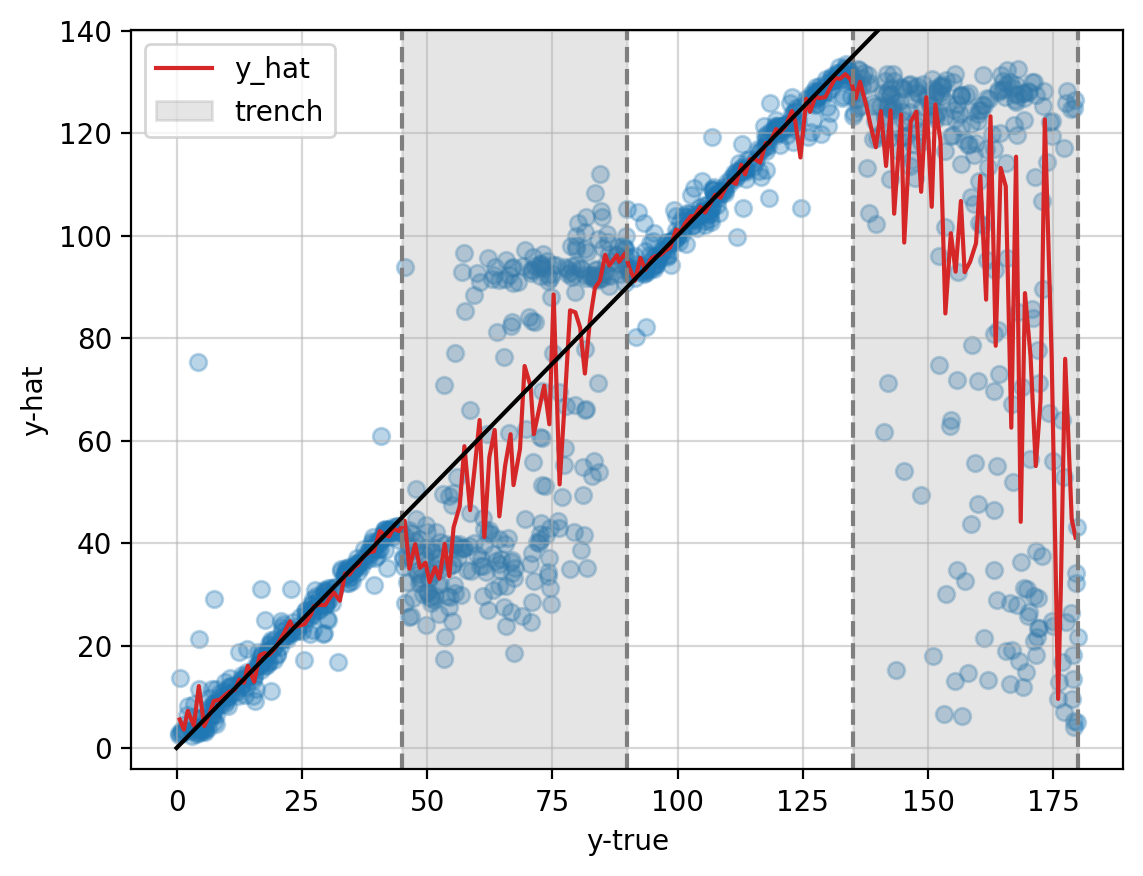

In [812]:
residual_err = yhat_test
fig, ax = plt.subplots()

summary.plot(x="y_true", y="y_hat", ax=ax, c="tab:red")

plt.scatter(y_test, residual_err, alpha=0.3, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

### Evaluating the posterior predictive as a function of rotation angle

In [857]:
ix_target = 1
x_target = np.array(X_eval[ix_target]).reshape(28, 28)
y_init = float(y_eval[ix_target].item())
x_target = datasets.rotate_mnist(x_target, -y_init).ravel()

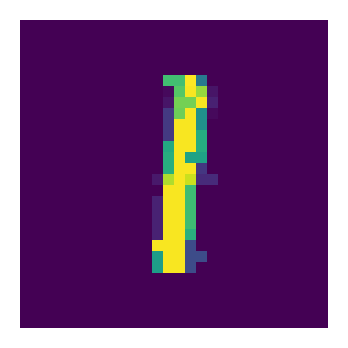

In [858]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(x_target.reshape(28, 28))
ax.axis("off");

We consider the same image rotated from 0 to 180 degrees

In [859]:
n_rotations = 1000
rotations = np.linspace(0, 2 * 360, n_rotations)
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 170, 100)

In [860]:
def generate_rotated_images(images, angles, n_processes=1):
    n_configs = len(images)
    processer = datasets.DataAugmentationFactory(datasets.rotate_mnist)
    configs = [{"angle": float(angle)} for angle in angles]
    images_proc = processer(images, configs, n_processes=n_processes)
    return images_proc, angles

In [861]:
X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
X_target = np.array(X_target.reshape(-1, 28, 28))
X_target, y_target = generate_rotated_images(X_target, rotations)

In [862]:
%%time
yhat_samples = rmodel.eval(sampled_params, X_target).squeeze()

CPU times: user 4.96 ms, sys: 61 µs, total: 5.02 ms
Wall time: 3.35 ms


In [863]:
yhat_mean = yhat_samples.mean(axis=0)
yhat_std = yhat_samples.std(axis=0)

In [864]:
y_train.mean()

Array(90.62268, dtype=float32)

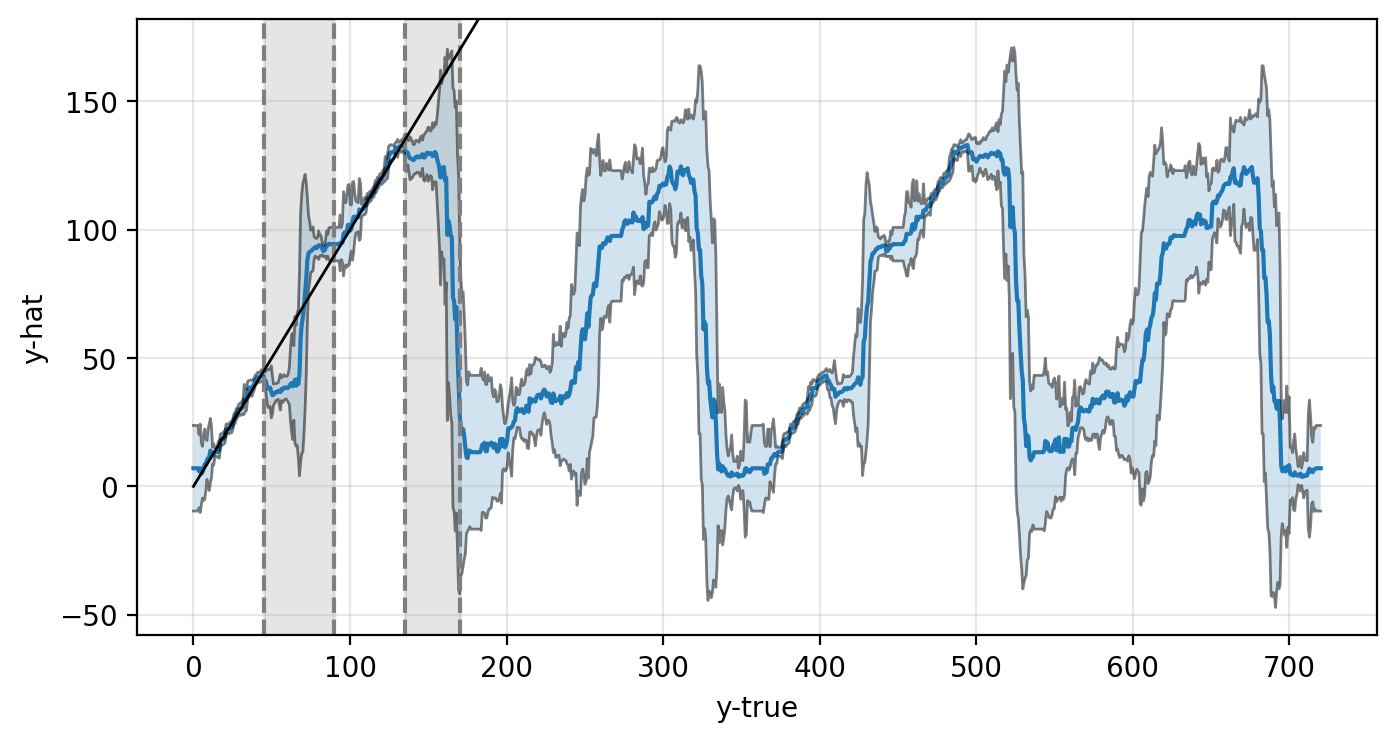

In [865]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(y_target, yhat_mean)

lbound = yhat_mean - 1.96 * yhat_std
ubound = yhat_mean + 1.96 * yhat_std
plt.fill_between(y_target, lbound, ubound, alpha=0.2)
plt.plot(y_target, lbound, c="black", linewidth=1, alpha=0.5)
plt.plot(y_target, ubound, c="black", linewidth=1, alpha=0.5)

plt.xlabel("y-true")
plt.ylabel("y-hat")

ymin, ymax  = plt.ylim()


plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=170, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

plt.plot([0, 360], [0, 360], c="black", linewidth=1)
plt.ylim(ymin, ymax)
plt.grid(alpha=0.3)

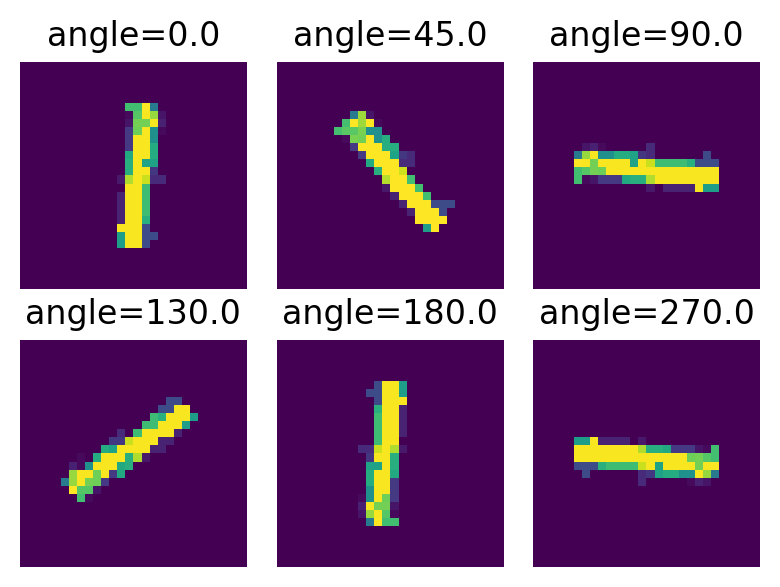

In [866]:
rotations = [0, 45, 90, 130, 180, 270]
n_rotations = len(rotations)

X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
X_target = np.array(X_target.reshape(-1, 28, 28))
X_target, y_target = generate_rotated_images(X_target, rotations)
X_target = X_target.reshape(-1, 28 ** 2)

ixs = [0, 1, 2, 3, 4, 5]

fig, axs = plt.subplots(2, 3, figsize=(4, 3))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_target[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_target[ix]
    ax.set_title(f"{angle=:0.1f}")
plt.tight_layout()

# To TPU
X_target = jnp.array(X_target)
y_target = jnp.array(y_target)

In [867]:
rotations = [0, 180]
n_rotations = len(rotations)

In [868]:
X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
X_target = np.array(X_target.reshape(-1, 28, 28))
X_target, y_target = generate_rotated_images(X_target, rotations)
X_target = X_target.reshape(-1, 28 ** 2)

In [869]:
yhat_samples = rmodel.eval(sampled_params, X_target).squeeze()

In [877]:
yhat_mean = yhat_samples.mean(axis=0)

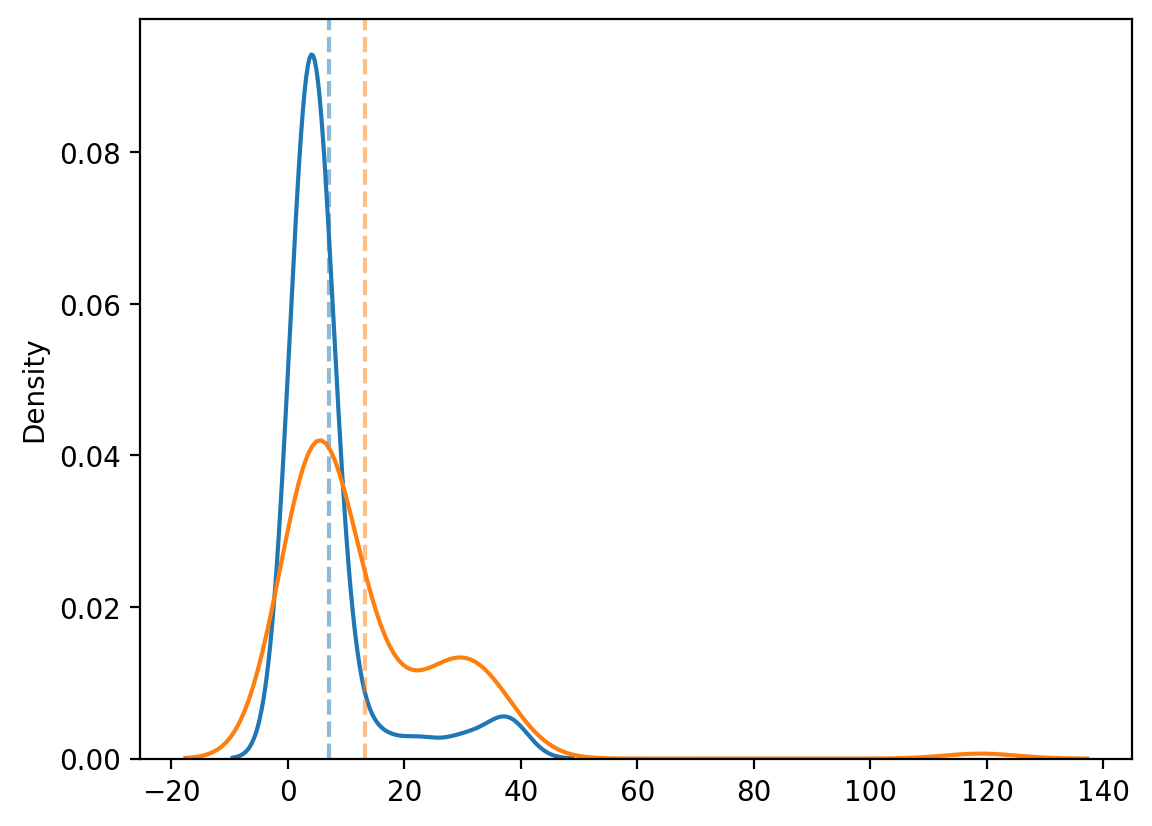

In [887]:
ix = 0
sns.kdeplot(yhat_samples[:, ix])
plt.axvline(x=yhat_mean[ix], linestyle="--", alpha=0.5)


ix = 1
sns.kdeplot(yhat_samples[:, ix], c="tab:orange")
plt.axvline(x=yhat_mean[ix], linestyle="--", c="tab:orange", alpha=0.5)